# Obtain

The data for all our Models was taken from the Kaggle competition whose URL is listed here:

https://www.kaggle.com/c/mens-march-mania-2022/data

This URL contains 20 CSVs of men's NCAA basketball data, but our code only uses eight of them:

MTeams: Contains teams current name and assigned TeamID, as well as number of years in the first division.

MNCAATourneySeeds: Identifies the seed for each team in every tournament in the data set.

MRegularSeasonCompactResults and MRegularSeasonDetailedResults: Contains general and detailed statistics for every game in the regular season (data goes back to 1985 for compact and back to 2003 for detailed). While compact results only contains points scored, detailed results contains statistics such as assists, rebounds, and fouls by both the winning and losing team.

MTourneyCompactResults and MTourneyDetailedResults: Contains the same statistics as the Regular Season CSVs but for the tournament games. 

MSampleSubmissionStage2: This file contains a Sample submission for the Kaggle competition. For the purposes of this project, we will be using this template to help structure our own results.

MMasseyOrdinals_thruDay128: Provides the ranking of teams through multiple ranking methodologies. More information can be found here: (https://masseyratings.com/cb/compare.htm). It goes till day 128 because that was the most recent data provided by Kaggle.

Keep in mind that these are just summaries of what these files contain. For information on what these files contain and the competition itself, please consult the URL linked above.

In [4]:
#https://www.kaggle.com/c/mens-march-mania-2022/data
#

In [67]:
# General Modules
import pandas as pd
import numpy as np

# Modules used in the Gradient Boost Model
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss

# Modules used in the Neural Network Model
from tensorflow import keras
from keras import layers
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

# Tracks the run time of each model
import time

# Modules for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# CSV files taken from Kaggle
tcr_df = pd.read_csv('MNCAATourneyCompactResults.csv')
# ts_df = pd.read_csv('MNCAATourneySeeds.csv')
rscr_df = pd.read_csv('MRegularSeasonCompactResults.csv')
ss_df = pd.read_csv('SampleSubmission2023.csv')
massey_df = pd.read_csv('MMasseyOrdinals_thru_Season2023_Day128.csv')
tbs_df = pd.read_csv('MNCAATourneyDetailedResults.csv')
rsbs_df = pd.read_csv('MRegularSeasonDetailedResults.csv') 
teams_df = pd.read_csv('MTeams.csv')

# Scrub

Due to the size and scope of the data provided, the following website was used to helped with data scrubbing:

https://www.activestate.com/blog/fantasy-march-madness-how-to-predict-winners/


In [7]:
# This function calculates the average points per game (PPG) of each team
# This function takes the Regular Season Compact Results as the input
def get_ppg(rscr_df):
    # Gametime normalization (accounts for overtime)
    rscr_df['GameDuration'] = rscr_df['NumOT']
    for i in range(len(rscr_df.NumOT.value_counts())):
        rscr_df.loc[rscr_df['NumOT'] == rscr_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5
    rscr_df['Wppg'] = (rscr_df['WScore'] / rscr_df['GameDuration']) * 40
    rscr_df['Lppg'] = (rscr_df['LScore'] / rscr_df['GameDuration']) * 40
    # Drop unnecesary columns 
    rscr_df = rscr_df.drop(['DayNum', 'WLoc', 'NumOT', 'WScore','LScore','GameDuration'], axis = 1)
    # Calculate average points per game and number of games for winning and losing team
    Wppg_df = rscr_df[["Season","WTeamID",'Wppg']].groupby(["Season","WTeamID"]).agg(['mean', 'count'])
    Lppg_df = rscr_df[["Season","LTeamID",'Lppg']].groupby(["Season","LTeamID"]).agg(['mean', 'count'])
    Wppg_df.columns = Wppg_df.columns.droplevel(0)
    Wppg_df = Wppg_df.reset_index().rename(columns = {'mean':'Wppg', 'count':'WGames'})
    Lppg_df.columns = Lppg_df.columns.droplevel(0)
    Lppg_df = Lppg_df.reset_index().rename(columns = {'mean':'Lppg', 'count':'LGames'})
    # Merge PPG for wins and losses and fill NaNs with 0s for undefeated and no-win teams
    ppg_df = pd.merge(Wppg_df, Lppg_df, left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'], how='outer')
    ppg_df = ppg_df.fillna({'WTeamID': ppg_df.LTeamID, 'Wppg': 0, 'WGames': 0, 'LTeamID': ppg_df.WTeamID , 'Lppg': 0, 'LGames': 0})
    # Calculate PPG and win percentage for season 
    ppg_df['PPG'] = (ppg_df['Wppg']*ppg_df['WGames'] + ppg_df['Lppg']*ppg_df['LGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df['WPerc'] = (ppg_df['WGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df['TeamID'] = ppg_df['WTeamID'].astype('int32')
    ppg_df['GamesPlayed'] = (ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df = ppg_df.drop(['WTeamID', 'Wppg' ,'WGames','LTeamID', 'Lppg','LGames'],axis = 1)
    return ppg_df 


It should be noted that normalizing for overtime games was an important step because it would inflate the metrics of teams that had multiple overtime games. It should also be noted that rows of the input df are game statistics while the rows of the output df are team statistics by season.

After running the function, we are left with the average Points per Game, Win Percentage, and Games Played for each team by season.

In [8]:
# Prints the resulting PPG data frame
ppg_df = get_ppg(rscr_df)
print(ppg_df.tail())

       Season        PPG  WPerc  TeamID  GamesPlayed
12657    2015  51.111111    0.0    1212         27.0
12658    2015  52.265873    0.0    1363         28.0
12659    2021  55.444444    0.0    1152          9.0
12660    2022  60.248889    0.0    1175         25.0
12661    2022  60.888889    0.0    1249         27.0


The next function has a similar goal to that of the get_ppg() function, but it obtains the important metrics from the detailed (rather than the compact) regular season results. All the statistics are summarized in a metric created by original writer of the code (link above) that averages certain statistics over the entire the regular season. The 30-day efficiency, which is the last 30 days of the regular season, accounts for momentum heading into the tournament.

Offensive Efficiency = Points Made + Assists + Offensive Rebounds

Defensive Efficiency = Points Missed (by Opponent) + Steals + Blocks + Defensive Rebounds + Turnovers (by Opponent) - Personal Fouls

In [9]:
# This function takes the Detailed Season Compact Results as the input
def get_efficiency(rsbs_df):
    # Gametime normalization 
    rsbs_df['GameDuration'] = rsbs_df['NumOT']
    for i in range(len(rsbs_df.NumOT.value_counts())):
        rsbs_df.loc[rsbs_df['NumOT'] == rsbs_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5

    # Normalizing winning team statisitcs
    rsbs_df['WFGM'] = (rsbs_df['WFGM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGA'] = (rsbs_df['WFGA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGM3'] = (rsbs_df['WFGM3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGA3'] = (rsbs_df['WFGA3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFTM'] = (rsbs_df['WFTM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFTA'] = (rsbs_df['WFTA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WOR'] = (rsbs_df['WOR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WDR'] = (rsbs_df['WDR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WAst'] = (rsbs_df['WAst'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WTO'] = (rsbs_df['WTO'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WStl'] = (rsbs_df['WStl'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WBlk'] = (rsbs_df['WBlk'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WPF'] = (rsbs_df['WPF'] / rsbs_df['GameDuration']) * 40
    # Normalizing losing Team statitics
    rsbs_df['LFGM'] = (rsbs_df['LFGM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGA'] = (rsbs_df['LFGA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGM3'] = (rsbs_df['LFGM3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGA3'] = (rsbs_df['LFGA3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFTM'] = (rsbs_df['LFTM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFTA'] = (rsbs_df['LFTA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LOR'] = (rsbs_df['LOR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LDR'] = (rsbs_df['LDR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LAst'] = (rsbs_df['LAst'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LTO'] = (rsbs_df['LTO'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LStl'] = (rsbs_df['LStl'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LBlk'] = (rsbs_df['LBlk'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LPF'] = (rsbs_df['LPF'] / rsbs_df['GameDuration']) * 40
    # Calculate total points made and missed per game 
    rsbs_df['wPointsMade'] = (2* (rsbs_df['WFGM'] - rsbs_df['WFGM3'])) + 3*rsbs_df['WFGM3'] + rsbs_df['WFTM']
    rsbs_df['wPointsMissed'] = (2* (rsbs_df['WFGA'] - rsbs_df['WFGA3'])) + 3*rsbs_df['WFGA3'] + rsbs_df['WFTA'] - rsbs_df['wPointsMade']
    rsbs_df['lPointsMade'] = (2* (rsbs_df['LFGM'] - rsbs_df['LFGM3'])) + 3*rsbs_df['LFGM3'] + rsbs_df['LFTM']
    rsbs_df['lPointsMissed'] = (2* (rsbs_df['LFGA'] - rsbs_df['LFGA3'])) + 3*rsbs_df['LFGA3'] + rsbs_df['LFTA'] - rsbs_df['lPointsMade']
    # Calculate offensive and defensive efficiency metrics for winning and losing team 
    rsbs_df['WoEFF'] = rsbs_df['wPointsMade'] +  rsbs_df['WAst'] + rsbs_df['WOR']
    rsbs_df['WdEFF'] = rsbs_df['lPointsMissed'] + rsbs_df['WStl'] + rsbs_df['WBlk'] + rsbs_df['WDR'] + rsbs_df['LTO'] - rsbs_df['WPF']
    rsbs_df['LoEFF'] = rsbs_df['lPointsMade'] +  rsbs_df['LAst'] + rsbs_df['LOR']
    rsbs_df['LdEFF'] = rsbs_df['wPointsMissed'] + rsbs_df['LStl'] + rsbs_df['LBlk'] + rsbs_df['LDR'] + rsbs_df['WTO'] - rsbs_df['LPF']
    # Extract relevant columns and rename 
    Weff_df = rsbs_df[['Season', 'DayNum', 'WTeamID','WoEFF', 'WdEFF']]
    Weff_df = Weff_df.rename(columns = {'WTeamID': 'TeamID','WoEFF': 'oEFF', 'WdEFF': 'dEFF'})
    Leff_df = rsbs_df[['Season', 'DayNum', 'LTeamID','LoEFF', 'LdEFF']]
    Leff_df = Leff_df.rename(columns = {'LTeamID': 'TeamID','LoEFF': 'oEFF', 'LdEFF': 'dEFF'})
    eff_df = pd.concat([Weff_df, Leff_df]) 
    # Take seasonal and 30 day averages of the efficiency metrics
    effseas_df = eff_df.groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    # eff30day_df = eff_df[eff_df.DayNum >= 100].groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    eff30day_df = eff_df[eff_df.DayNum >= 98].groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    eff30day_df = eff30day_df.rename(columns = {'oEFF': 'oEFF_30day', 'dEFF': 'dEFF_30day' })
    eff_df = pd.merge(effseas_df,eff30day_df, how = 'outer', on = ['Season', 'TeamID']) 
    return eff_df 

The resulting output consists of the Offensive and Defensive Efficiency (both overall and the over the last 30 days in the data) by team for every season going back to 2003.

Future Improvement Opportunity: Identify all tournament champions from 2003-2022 and see where they stack up efficiency-wise compared to their competition. 

In [10]:
# Prints the resulting efficiency data frame
eff_df = get_efficiency(rsbs_df)
print(eff_df.head())

   Season  TeamID        oEFF        dEFF  oEFF_30day  dEFF_30day
0    2003    1102   74.428571   78.321429   71.500000   66.625000
1    2003    1103  100.188477   97.734156   93.666667   99.472222
2    2003    1104   94.599206  112.023810   96.750000  109.125000
3    2003    1105   97.922222  114.037607  106.358025  114.888889
4    2003    1106   87.134921  111.956349   84.333333  108.555556


This function seeks the summarize the Massey Ordinals data. Since there are various ranking metrics within this dataset, we will be finding the mean and median of all of them for the last day available (Day 128). We will also be using the Massey rank as its own column because it is the most accurate.

In [11]:
# This function takes in the Massey Ordinals as the input
def get_rank(massey_df):
  # Gets the data from the last day available
    rankings_df = massey_df[massey_df['RankingDayNum'] == 128]
    rankings_df = rankings_df.reset_index().drop(['index','RankingDayNum'], axis = 1)
    # Finds the median of all the rankings
    median_df = rankings_df.groupby(by = ['Season','TeamID'])[['OrdinalRank']].median().reset_index()
    median_df = median_df.rename(columns = {'OrdinalRank':'MedianRank'})
    # Finds the mean of all the rankings
    mean_df = rankings_df.groupby(by = ['Season','TeamID'])[['OrdinalRank']].mean().reset_index()
    mean_df = mean_df.rename(columns = {'OrdinalRank':'MeanRank'})
    # Isolates the Massey ranking as its own column
    massey_df = rankings_df[rankings_df['SystemName'] == 'MAS']
    massey_df = massey_df.reset_index().drop(['index','SystemName'], axis = 1)
    massey_df = massey_df.rename(columns = {'OrdinalRank':'MasseyRank'})
    # Merges the data into one data frame
    rankings_df = pd.merge(median_df, massey_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
    rankings_df = pd.merge(rankings_df, mean_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
    return rankings_df 

In [12]:
# Prints the resulting rankings data frame
rankings_df = get_rank(massey_df)
print(rankings_df.tail())

      Season  TeamID  MedianRank  MasseyRank    MeanRank
7249    2023    1473       340.0       350.0  340.000000
7250    2023    1474       206.0       219.0  206.435484
7251    2023    1475       272.0       300.0  272.887097
7252    2023    1476       321.5       324.0  316.032258
7253    2023    1477       311.0       323.0  309.612903


This function will help us get our results into the correct format, and (in so doing) create the testing data. The data consists of five columns:

ID (Season_TeamID(lower)_TeamID(higher))

Season

TeamID_1

TeamID_2

Result

In [13]:
'''
This data frame takes the Sample Submission and Tournament Compact Results as
the input.
'''
def prep_submission(ss_df,tcr_df):
    features_df = ss_df.copy()
    # extract season and team IDs
    features_df['Season'] = features_df['ID'].map(lambda x: int(x[:4]))
    features_df['WTeamID'] = features_df['ID'].map(lambda x: int(x[5:9]))
    features_df['LTeamID'] = features_df['ID'].map(lambda x: int(x[10:14]))
    features_df = features_df.rename(columns= {'WTeamID':'TeamID_1','LTeamID':'TeamID_2'})
    # Extract seasons starting from 2016 and create Result column corresponding to winner and loser
    Wtcr_df = tcr_df[tcr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Wtcr_df = Wtcr_df.rename(columns = {'WTeamID': 'TeamID_1', 'LTeamID': 'TeamID_2'})
    Wtcr_df['Result'] = 1
    Ltcr_df = tcr_df[tcr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Ltcr_df = Ltcr_df.rename(columns = {'WTeamID': 'TeamID_2', 'LTeamID': 'TeamID_1'})
    Ltcr_df['Result'] = 0
    tcr_df = pd.concat([Wtcr_df,Ltcr_df], sort=False).reset_index().drop('index', axis = 1)
    tcr_df['ID'] = tcr_df['Season'].apply(str) + '_' + tcr_df['TeamID_1'].apply(str) + '_' + tcr_df['TeamID_2'].apply(str)
    tcr_df = tcr_df.drop(['Season', 'TeamID_1', 'TeamID_2'],axis = 1)
    # merge results onto sample submission
    features_df = pd.merge(features_df,tcr_df, how = 'left', on = 'ID')
    features_df = features_df.drop(['Pred'],axis = 1)
    return features_df 

The Results column is blank because this code generates all possible matchups between teams (not just the ones that happened). These rows will be removed later.

In [14]:
# Prints the resulting submission data frame
features_df = prep_submission(ss_df,tcr_df)
print(features_df.head())

               ID  Season  TeamID_1  TeamID_2  Result
0  2023_1101_1102    2023      1101      1102     NaN
1  2023_1101_1103    2023      1101      1103     NaN
2  2023_1101_1104    2023      1101      1104     NaN
3  2023_1101_1105    2023      1101      1105     NaN
4  2023_1101_1106    2023      1101      1106     NaN


This function has a similar output to the prep_submission function but it uses the regular season compact results to create the training data. We will be using the 2016-2021 data as a they are the most recent complete seasons (2020 will be excluded).

In [15]:
def prep_regseason(rscr_df):  
    # Extract seasons starting from 2017 and create Result column corresponding to winner and loser
    Wrscr_df = rscr_df[rscr_df.Season >= 2017].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Wrscr_df = Wrscr_df.rename(columns = {'WTeamID': 'TeamID_1', 'LTeamID': 'TeamID_2'})
    Wrscr_df['Result'] = 1
    Lrscr_df = rscr_df[rscr_df.Season >= 2017].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Lrscr_df = Lrscr_df.rename(columns = {'WTeamID': 'TeamID_2', 'LTeamID': 'TeamID_1'})
    Lrscr_df['Result'] = 0
    rscr_df = pd.concat([Wrscr_df,Lrscr_df], sort=False).reset_index().drop('index', axis = 1)
    rscr_df['ID'] = rscr_df['Season'].apply(str) + '_' + rscr_df['TeamID_1'].apply(str) + '_' + rscr_df['TeamID_2'].apply(str)
    return rscr_df 

In [16]:
# Prints the resulting regular season (training) data frame
rscr_df = prep_regseason(rscr_df)
print(rscr_df.head())

   Season  TeamID_1  TeamID_2  Result              ID
0    2017      1104      1157       1  2017_1104_1157
1    2017      1107      1336       1  2017_1107_1336
2    2017      1112      1277       1  2017_1112_1277
3    2017      1113      1340       1  2017_1113_1340
4    2017      1116      1236       1  2017_1116_1236


This function serves to put everything together. It takes in a features_df (which can be either the train or test data frame) and finds the corresponding statistics given the teams and season. 

In [17]:
def merge_features(features_df, ppg_df,eff_df,rankings_df):
    # Finds the PPG metrics for each row in the features_df
    Wppg_df = ppg_df.rename(columns = {'PPG':'PPG_1','WPerc':'WPerc_1'})
    Lppg_df = ppg_df.rename(columns = {'PPG':'PPG_2','WPerc':'WPerc_2'})
    Wfeatures_df = pd.merge(features_df, Wppg_df,left_on=['Season', 'TeamID_1'], right_on=['Season', 'TeamID'], how='left')
    Wfeatures_df = Wfeatures_df.drop(['TeamID', 'GamesPlayed'], axis = 1)
    features_df = pd.merge(Wfeatures_df, Lppg_df,left_on=['Season', 'TeamID_2'], right_on=['Season', 'TeamID'], how='left')
    features_df = features_df.drop(['TeamID', 'GamesPlayed'], axis = 1)

    # Finds the efficiency metrics for each row in the features_df
    Weff_df = eff_df.rename(columns = {'oEFF': 'oEFF_1', 'dEFF': 'dEFF_1','oEFF_30day': 'oEFF_30day_1', 'dEFF_30day': 'dEFF_30day_1'})
    Leff_df = eff_df.rename(columns = {'oEFF': 'oEFF_2', 'dEFF': 'dEFF_2','oEFF_30day': 'oEFF_30day_2', 'dEFF_30day': 'dEFF_30day_2'})
    features_df = pd.merge(features_df, Weff_df, how = 'left', left_on = ['Season', 'TeamID_1'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'], axis = 1)
    features_df = pd.merge(features_df, Leff_df, how = 'left', left_on = ['Season', 'TeamID_2'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'], axis = 1)
    features_df['PPG_diff'] = features_df['PPG_1'] - features_df['PPG_2']
    features_df['WPerc_diff'] = features_df['WPerc_1'] - features_df['WPerc_2']
    features_df['oEFF_diff'] = features_df['oEFF_1'] - features_df['oEFF_2']
    features_df['dEFF_diff'] = features_df['dEFF_1'] - features_df['dEFF_2']
    features_df['oEFF_30day_diff'] = features_df['oEFF_30day_1'] - features_df['oEFF_30day_2']
    features_df['dEFF_30day_diff'] = features_df['dEFF_30day_1'] - features_df['dEFF_30day_2']
    features_df = features_df.drop(['PPG_1', 'WPerc_1', 'PPG_2', 'WPerc_2', 'oEFF_1', 'dEFF_1', 'oEFF_30day_1', 
                                    'dEFF_30day_1', 'oEFF_2', 'dEFF_2', 'oEFF_30day_2', 'dEFF_30day_2'], axis = 1)
    
    # Finds the rankings metrics for each row in the features_df
    Wrankings_df = rankings_df.rename(columns = {'MedianRank': 'MedianRank_1', 'MasseyRank': 'MasseyRank_1', 'MeanRank' : 'MeanRank_1'})
    Lrankings_df = rankings_df.rename(columns = {'MedianRank': 'MedianRank_2', 'MasseyRank': 'MasseyRank_2', 'MeanRank' : 'MeanRank_2'})
    features_df = pd.merge(features_df,Wrankings_df, how = 'left', left_on = ['Season', 'TeamID_1'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'],axis = 1)
    features_df = pd.merge(features_df,Lrankings_df, how = 'left', left_on = ['Season', 'TeamID_2'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'],axis = 1)
    features_df['MedianRank_diff'] = features_df['MedianRank_1'] - features_df['MedianRank_2']
    features_df['MasseyRank_diff'] = features_df['MasseyRank_1'] - features_df['MasseyRank_2']
    features_df['MeanRank_diff'] = features_df['MeanRank_1'] - features_df['MeanRank_2']
    features_df = features_df.drop(['MedianRank_1', 'MasseyRank_1', 'MeanRank_1',
                                    'MedianRank_2', 'MasseyRank_2', 'MeanRank_2'], axis = 1)
    return features_df 

This code also calculates the difference of these metrics between the two teams, which is what is put into the final data frames.

What we are left with is a training set made from the regular season statistics and a test set made from the tournament statistics. 

In [18]:
# Prepare regular season df for 2016-2021, i.e. training set
# Will exclude 2020
regseason_df = merge_features(rscr_df, ppg_df,eff_df,rankings_df)

print(regseason_df.head())

   Season  TeamID_1  TeamID_2  Result              ID  PPG_diff  WPerc_diff  \
0    2017      1104      1157       1  2017_1104_1157 -2.450310    0.124145   
1    2017      1107      1336       1  2017_1107_1336  0.637588    0.151515   
2    2017      1112      1277       1  2017_1112_1277  4.789958    0.306595   
3    2017      1113      1340       1  2017_1113_1340 -1.086099    0.025974   
4    2017      1116      1236       1  2017_1116_1236 -3.824930    0.163866   

   oEFF_diff  dEFF_diff  oEFF_30day_diff  dEFF_30day_diff  MedianRank_diff  \
0  -2.298794  -7.271098        -7.951515        -7.138384           -126.0   
1   0.557086 -15.040404         3.901235        -6.814815             57.0   
2   2.514557   3.075361         5.000000         1.900000            -29.5   
3  -2.788576   3.920178       -12.634568         3.356790           -126.0   
4  -5.349673   2.033613       -12.229437        15.425685           -112.0   

   MasseyRank_diff  MeanRank_diff  
0           -118.0  

In [19]:
# Prepare tournament submission df for 2016-2021, i.e. test set. 
# Will exclude 2020
tournament_df = merge_features(features_df, ppg_df,eff_df,rankings_df)

print(tournament_df.head())

               ID  Season  TeamID_1  TeamID_2  Result   PPG_diff  WPerc_diff  \
0  2023_1101_1102    2023      1101      1102     NaN   4.363355   -0.091346   
1  2023_1101_1103    2023      1101      1103     NaN  -3.046816   -0.299007   
2  2023_1101_1104    2023      1101      1104     NaN -10.094570   -0.506787   
3  2023_1101_1105    2023      1101      1105     NaN   3.023077   -0.053846   
4  2023_1101_1106    2023      1101      1106     NaN   8.297151    0.112821   

   oEFF_diff  dEFF_diff  oEFF_30day_diff  dEFF_30day_diff  MedianRank_diff  \
0   5.803900  -8.058333        -0.286111       -14.280556             54.5   
1  -2.144913 -15.205735       -15.566667       -20.166667            101.0   
2 -13.926697 -39.822222       -18.527273       -42.711111            207.5   
3   4.448205 -19.300000        -0.540000       -26.700000           -102.5   
4  10.480057 -17.125926         3.450000       -23.725000           -141.5   

   MasseyRank_diff  MeanRank_diff  
0             

As we said earlier, we will only be considering 2016-2021 (excluding 2020). We will isolate those seasons here.

In [20]:
# Note: not all matchups have Results, as we predict all possible matchups for 
# the 5 seasons when only around 335 games actually occur

# Drop matchups that don’t occur, as we cannot evaluate them
regseason_df = regseason_df.dropna()

# Stores regular season statisitcs into dfs by year
regseason_df_2017 = regseason_df[regseason_df.Season == 2017]
regseason_df_2018 = regseason_df[regseason_df.Season == 2018]
regseason_df_2019 = regseason_df[regseason_df.Season == 2019]
regseason_df_2021 = regseason_df[regseason_df.Season == 2021]
regseason_df_2022 = regseason_df[regseason_df.Season == 2022]
# regseason_df_2022 = regseason_df[regseason_df.Season == 2023] 

# Combines the five individual dfs into one giant df
# Uses 2016-2021 (Excluding 2020)
megareg_df = pd.concat([regseason_df_2017, regseason_df_2018, 
regseason_df_2019, regseason_df_2021, regseason_df_2022], ignore_index = True, 
axis = 0)

'''
# Combines the five individual dfs into one giant df
# Uses 2017-2022 (Excluding 2020)
megareg_df = pd.concat([regseason_df_2017, regseason_df_2018, 
regseason_df_2019, regseason_df_2021, regseason_df_2022], ignore_index = True, 
axis = 0)
'''


'\n# Combines the five individual dfs into one giant df\n# Uses 2017-2022 (Excluding 2020)\nmegareg_df = pd.concat([regseason_df_2017, regseason_df_2018, \nregseason_df_2019, regseason_df_2021, regseason_df_2022], ignore_index = True, \naxis = 0)\n'

In [21]:
# Drop matchups that don’t occur, as we cannot evaluate them
tournament_df = tournament_df.dropna()

# Stores tournament statisitcs into dfs by year
tournament_df_2017 = tournament_df[tournament_df.Season == 2017]
tournament_df_2018 = tournament_df[tournament_df.Season == 2018]
tournament_df_2019 = tournament_df[tournament_df.Season == 2019]
tournament_df_2021 = tournament_df[tournament_df.Season == 2021]
tournament_df_2022 = tournament_df[tournament_df.Season == 2022]

# Combines the five individual dfs into one giant df
megatourney_df = pd.concat([tournament_df_2017, tournament_df_2018, 
                            tournament_df_2019, tournament_df_2021,
                            tournament_df_2022], 
ignore_index = True, axis = 0)


For both models, the independent variables will be the teams statistics we collected while the dependent variable will be the result of the game.

In [22]:
# Regular season stats and results become the training data
X_train = megareg_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff', 'MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_train = megareg_df[['Result']] 

# Tournament stats and results become the test data
X_test = megatourney_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                        'dEFF_30day_diff', 'MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_test = megatourney_df[['Result']]  


# Explore

Before we start modeling, we will look at the teams in the tournament, below are the teams in the 2022 tournament, where each row is a matchup.

Below, I have also included the actual matchups for the later stages of the tournament. One of the main issues in predicting matchups in a tournament is that if a matchup in the first round is predicted incorrectly it effects subsequent matchups. In future analysis, I will run the code starting at later stages of the tournament and report the results. 

In [23]:
# 2022 Bracket
'''
# Matchups of the first round of the 2022 tournament
r64_matchups = ['Gonzaga', 'Georgia St',
            'Boise St', 'Memphis',
            'Connecticut', 'New Mexico St', 
            'Arkansas', 'Vermont',  
            'Alabama', 'Notre Dame', 
            'Texas Tech', 'Montana St', 
            'Michigan St', 'Davidson', 
            'Duke', 'CS Fullerton', 
            'Baylor', 'Norfolk St', 
            'North Carolina', 'Marquette', 
            'St Mary\'s CA', 'Indiana', 
            'UCLA', 'Akron', 
            'Texas', 'Virginia Tech', 
            'Purdue', 'Yale', 
            'Murray St', 'San Francisco', 
            'Kentucky', 'St Peter\'s',  
            'Arizona', 'Wright St', 
            'Seton Hall', 'TCU', 
            'Houston', 'UAB', 
            'Illinois', 'Chattanooga', 
            'Colorado St', 'Michigan', 
            'Tennessee', 'Longwood', 
            'Ohio St', 'Loyola-Chicago', 
            'Villanova', 'Delaware', 
            'Kansas', 'TX Southern', 
            'San Diego St', 'Creighton', 
            'Iowa', 'Richmond', 
            'Providence', 'S Dakota St', 
            'LSU', 'Iowa St', 
            'Wisconsin', 'Colgate',
            'USC', 'Miami FL',
            'Auburn', 'Jacksonville St']

# Actual Round of 32 matchups
r32_actual = ['Gonzaga', 'Memphis',
            'New Mexico St', 'Arkansas',   
            'Notre Dame', 'Texas Tech',  
            'Michigan St', 'Duke',
            'Baylor', 'North Carolina', 
            'St Mary\'s CA', 'UCLA', 
            'Texas', 'Purdue',
            'Murray St', 'St Peter\'s',  
            'Arizona', 'TCU',
            'Houston', 'Illinois', 
            'Michigan', 'Tennessee', 
            'Ohio St', 'Villanova',
            'Kansas', 'Creighton', 
            'Richmond', 'Providence', 
            'Iowa St', 'Wisconsin', 
            'Miami FL', 'Auburn']

# Actual Sweet 16 matchups
s16_actual = ['Gonzaga', 'Arkansas',   
            'Texas Tech', 'Duke',
            'North Carolina', 'UCLA', 
            'Purdue', 'St Peter\'s',  
            'Arizona', 'Houston',
            'Michigan', 'Villanova',
            'Kansas', 'Providence', 
            'Iowa St', 'Miami FL']

# Actual Elite 8 matchups
e8_actual = ['Arkansas', 'Duke',
            'North Carolina', 'St Peter\'s',  
            'Houston', 'Villanova',
            'Kansas', 'Miami FL']

# Actual Final 4 matchups
f4_actual = ['Duke', 'North Carolina',  
            'Villanova', 'Kansas']

# Actual Championship matchup
champ_actual = ['North Carolina', 'Kansas']

# Kansas was the eventual champion of the Tournament
'''

"\n# Matchups of the first round of the 2022 tournament\nr64_matchups = ['Gonzaga', 'Georgia St',\n            'Boise St', 'Memphis',\n            'Connecticut', 'New Mexico St', \n            'Arkansas', 'Vermont',  \n            'Alabama', 'Notre Dame', \n            'Texas Tech', 'Montana St', \n            'Michigan St', 'Davidson', \n            'Duke', 'CS Fullerton', \n            'Baylor', 'Norfolk St', \n            'North Carolina', 'Marquette', \n            'St Mary's CA', 'Indiana', \n            'UCLA', 'Akron', \n            'Texas', 'Virginia Tech', \n            'Purdue', 'Yale', \n            'Murray St', 'San Francisco', \n            'Kentucky', 'St Peter's',  \n            'Arizona', 'Wright St', \n            'Seton Hall', 'TCU', \n            'Houston', 'UAB', \n            'Illinois', 'Chattanooga', \n            'Colorado St', 'Michigan', \n            'Tennessee', 'Longwood', \n            'Ohio St', 'Loyola-Chicago', \n            'Villanova', 'Delaware', \n 

In [24]:
# 2023 Bracket

# Matchups of the first round of the 2023 tournament
r64_matchups = ['Alabama', 'TAM C. Christi', 
            'Maryland', 'West Virginia',
            'San Diego St', 'Charleston So', 
            'Virginia', 'Furman',  
            'Creighton', 'NC State', 
            'Baylor', 'UC Santa Barbara', 
            'Missouri', 'Utah St', 
            'Arizona', 'Princeton', 
            'Purdue', 'F Dickinson', 
            'Memphis', 'FL Atlantic', 
            'Duke', 'Oral Roberts', 
            'Tennessee', 'Lafayette', 
            'Kentucky', 'Providence', 
            'Kansas St', 'Montana St', 
            'Michigan St', 'USC', 
            'Marquette', 'Vermont',  
            'Houston', 'N Kentucky', 
            'Iowa', 'Auburn', 
            'Miami FL', 'Drake', 
            'Indiana', 'Kent', 
            'Iowa St', 'Pittsburgh', 
            'Xavier', 'Kennesaw', 
            'Texas A&M', 'Penn St', 
            'Texas', 'Colgate', 
            'Kansas', 'Howard', 
            'Arkansas', 'Illinois', 
            'St Mary\'s CA', 'VCU', 
            'Connecticut', 'Iona', 
            'TCU', 'Arizona St', 
            'Gonzaga', 'Grand Canyon',
            'Northwestern', 'Boise St',
            'UCLA', 'UNC Asheville']

# Actual Round of 32 matchups
r32_actual = ['Alabama', 'Maryland',
            'San Diego St', 'Furman',  
            'Creighton', 'Baylor', 
            'Missouri', 'Princeton', 
            'F Dickinson', 'FL Atlantic', 
            'Duke', 'Tennessee',
            'Kentucky', 'Kansas St',
            'Michigan St', 'Marquette',  
            'Houston', 'Auburn', 
            'Miami FL', 'Indiana', 
            'Pittsburgh', 'Xavier',
            'Penn St', 'Texas', 
            'Kansas', 'Arkansas',
            'St Mary\'s CA', 'Connecticut', 
            'TCU', 'Gonzaga',
            'Northwestern', 'UCLA']

# Actual Sweet 16 matchups
s16_actual = ['Alabama', 'San Diego St',  
            'Creighton', 'Princeton', 
            'FL Atlantic', 'Tennessee',
            'Kansas St', 'Michigan St',  
            'Houston', 'Miami FL', 
            'Xavier', 'Texas', 
            'Arkansas', 'Connecticut', 
            'Gonzaga', 'UCLA']

The function below gathers the information for all the teams in the 2022 tournament.

In [25]:
# Takes the teams_df, a input data frame, and a list of teams as the input
'''
def stats2022(teams_df, pjtm_df, teamlist):
  # Finds the teams in the list of matchups
  dff = teams_df[teams_df.TeamName.isin(teamlist)]
  # Subsets the input data frame, including only the teams in the tournament
  dff = pjtm_df[pjtm_df.TeamID.isin(dff.TeamID)]
  # Add the Team Name to the data frame
  dff = pd.merge(teams_df[['TeamName','TeamID']],dff,how = 'right', left_on = ['TeamID'], right_on = ['TeamID'])
  # Uses only data from the 2022 season
  dff = dff[dff.Season == 2022]
'''

  # Takes the teams_df, a input data frame, and a list of teams as the input
def stats2023(teams_df, pjtm_df, teamlist):
  # Finds the teams in the list of matchups
  dff = teams_df[teams_df.TeamName.isin(teamlist)]
  # Subsets the input data frame, including only the teams in the tournament
  dff = pjtm_df[pjtm_df.TeamID.isin(dff.TeamID)]
  # Add the Team Name to the data frame
  dff = pd.merge(teams_df[['TeamName','TeamID']],dff,how = 'right', left_on = ['TeamID'], right_on = ['TeamID'])
  # Uses only data from the 2023 season
  dff = dff[dff.Season == 2023]

  return(dff) 

In [26]:
'''
Finds the PPG, Effieciency, and Ranking data for the teams in the 2023 
tournament.
'''
ppg_stats = stats2023(teams_df, ppg_df, r64_matchups)
eff_stats = stats2023(teams_df, eff_df, r64_matchups)
rank_stats = stats2023(teams_df, rankings_df, r64_matchups)

# ppg_stats = stats2022(teams_df, ppg_df, e8_actual)
# eff_stats = stats2022(teams_df, eff_df, e8_actual)
# rank_stats = stats2022(teams_df, rankings_df, e8_actual)

print(ppg_stats.head())
print(eff_stats.head())
print(rank_stats.head())

        TeamName  TeamID  Season        PPG     WPerc  GamesPlayed
2318     Alabama    1104    2023  80.617647  0.852941         34.0
2319     Arizona    1112    2023  82.676471  0.823529         34.0
2320  Arizona St    1113    2023  69.663399  0.647059         34.0
2321    Arkansas    1116    2023  74.161616  0.606061         33.0
2322      Auburn    1120    2023  72.423611  0.625000         32.0
        TeamName  TeamID  Season        oEFF        dEFF  oEFF_30day  \
1255     Alabama    1104    2023  106.588235  132.222222  104.727273   
1256     Arizona    1112    2023  110.676471  127.323529  106.500000   
1257  Arizona St    1113    2023   93.019608  120.529412   90.511111   
1258    Arkansas    1116    2023   96.191919  114.006734   95.800000   
1259      Auburn    1120    2023   96.378472  116.204861   95.901235   

      dEFF_30day  
1255  126.111111  
1256  118.100000  
1257  113.888889  
1258  108.400000  
1259  101.283951  
        TeamName  TeamID  Season  MedianRank  Masse

Below are afew tables/charts detailing the 64 teams in the 2022 tournament. (The season has been changed to 2023)

In [27]:
# Top 5 Offenses
print('Top 5 Offenses:')
eff_stats.nlargest(5, 'oEFF')

Top 5 Offenses:


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1271,Gonzaga,1211,2023,111.385417,116.496528,119.444444,116.666667
1256,Arizona,1112,2023,110.676471,127.323529,106.500000,118.100000
1318,Xavier,1462,2023,109.346405,117.205882,100.000000,109.500000
1264,Connecticut,1163,2023,107.515152,111.393939,106.111111,112.111111
1255,Alabama,1104,2023,106.588235,132.222222,104.727273,126.111111


In [28]:
# Top 5 Defenses
print('Top 5 Defences:')
eff_stats.nlargest(5, 'dEFF')

Top 5 Defences:


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1255,Alabama,1104,2023,106.588235,132.222222,104.727273,126.111111
1296,Oral Roberts,1331,2023,104.000000,128.700000,102.333333,130.777778
1288,Memphis,1272,2023,103.054902,127.983007,101.181818,124.636364
1256,Arizona,1112,2023,110.676471,127.323529,106.500000,118.100000
1312,USC,1425,2023,93.954861,123.965278,92.666667,123.444444


In [29]:
print('Top 5 Offenses (30 Day Average):')
eff_stats.nlargest(5, 'oEFF_30day')

Top 5 Offenses (30 Day Average):


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1271,Gonzaga,1211,2023,111.385417,116.496528,119.444444,116.666667
1263,Colgate,1159,2023,102.969697,115.121212,111.555556,123.222222
1256,Arizona,1112,2023,110.676471,127.323529,106.500000,118.100000
1270,Furman,1202,2023,104.544803,109.311828,106.469136,112.839506
1289,Miami FL,1274,2023,103.003472,115.388889,106.222222,111.000000


In [30]:
print('Top 5 Defences (30 Day Average):')
eff_stats.nlargest(5, 'dEFF_30day')

Top 5 Defences (30 Day Average):


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1296,Oral Roberts,1331,2023,104.000000,128.700000,102.333333,130.777778
1255,Alabama,1104,2023,106.588235,132.222222,104.727273,126.111111
1288,Memphis,1272,2023,103.054902,127.983007,101.181818,124.636364
1312,USC,1425,2023,93.954861,123.965278,92.666667,123.444444
1263,Colgate,1159,2023,102.969697,115.121212,111.555556,123.222222


,TeamName,TeamID,Season,PPG,WPerc,GamesPlayed
2348,Lafayette,1248,2023,60.943791,0.323529,34.0


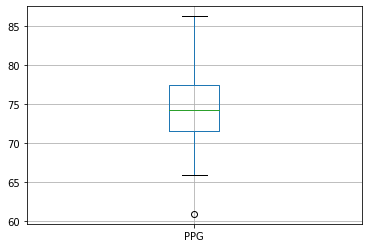

In [31]:
ppg_stats.boxplot('PPG')
# The four outliers in the boxplot are highlighted in the table below
ppg_stats.nsmallest(1, 'PPG')

<Axes: title={'center': 'Team Efficiency'}>

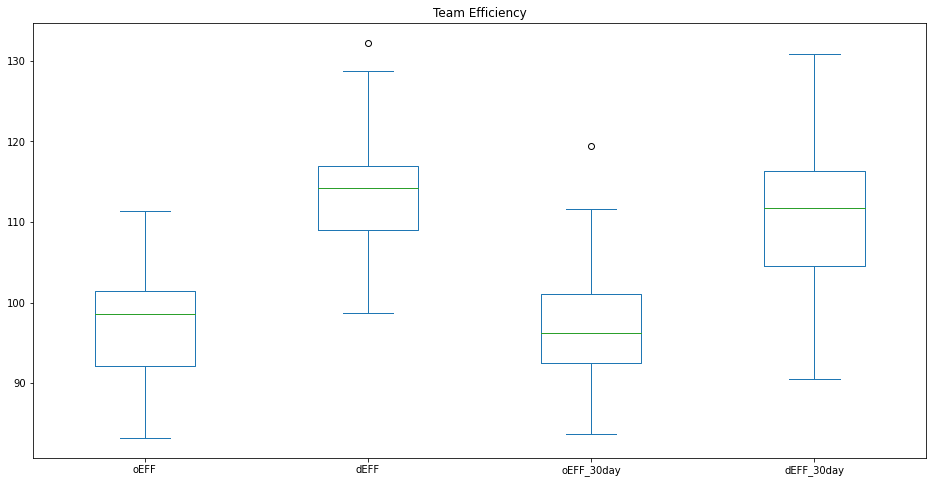

In [32]:
plt.rcParams['figure.figsize'] = [16, 8]
eff_stats[['oEFF', 'dEFF', 'oEFF_30day', 'dEFF_30day']].plot(kind='box', 
                                                             title='Team Efficiency')

In [33]:
# eff_stats.boxplot('oEFF')
# The outliers in the offensive and deffensive boxplot 

# print('Offensive and Defensive Outliers: ')

In [34]:
# eff_stats.boxplot('dEFF')
# The outliers in the boxplot are highlighted in the table below
eff_stats.nlargest(1, 'dEFF')

,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1255,Alabama,1104,2023,106.588235,132.222222,104.727273,126.111111


In [35]:
# eff_stats.boxplot('oEFF_30day')
# The two outliers in the boxplot are highlighted in the table below
eff_stats.nlargest(1, 'oEFF_30day')

,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1271,Gonzaga,1211,2023,111.385417,116.496528,119.444444,116.666667


In [36]:
# eff_stats.boxplot('dEFF_30day')

In the next plot, the two biggest outliers (Gonzaga and Arizona) are featured. I also labled Kansas (the eventual winners of the tournament).

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: title={'center': 'Offenseive vs. Defensive Efficiency'}, xlabel='oEFF', ylabel='dEFF'>

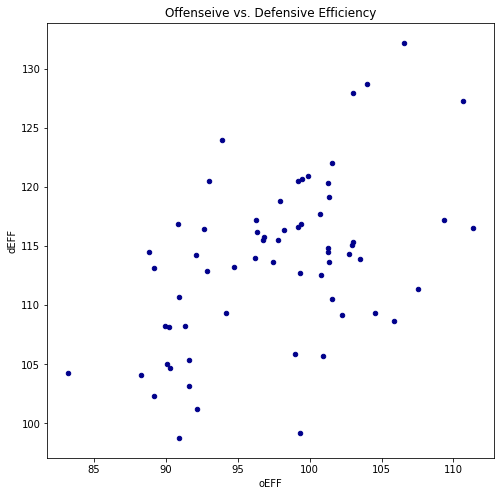

In [37]:
eff_stats.plot.scatter(x = 'oEFF', y = 'dEFF', c = 'DarkBlue', 
                       title = 'Offenseive vs. Defensive Efficiency', 
                       figsize = (8,8))


<Axes: title={'center': 'Overall vs. 30-Day oEFF'}, xlabel='oEFF', ylabel='oEFF_30day'>

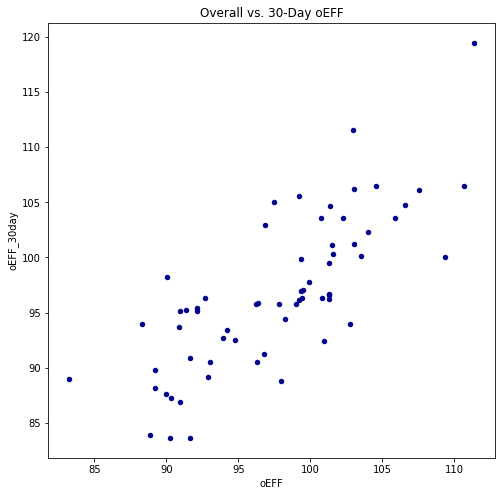

In [38]:
eff_stats.plot.scatter(x = 'oEFF', y = 'oEFF_30day', c = 'DarkBlue', 
                       title = 'Overall vs. 30-Day oEFF', 
                       figsize = (8,8))

<Axes: title={'center': 'Overall vs. 30-Day dEFF'}, xlabel='dEFF', ylabel='dEFF_30day'>

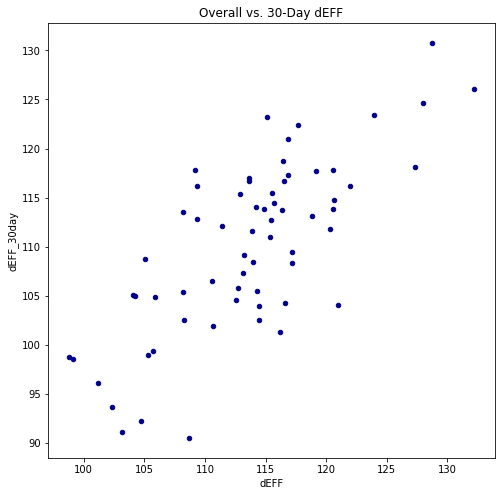

In [39]:
eff_stats.plot.scatter(x = 'dEFF', y = 'dEFF_30day', c = 'DarkBlue', 
                       title = 'Overall vs. 30-Day dEFF', 
                       figsize = (8,8))


Kansas, who were the eventual winners of this tournament, fall in the middle of the pack when it comes to offensive and deffensive efficiency. But they also were a one seed in the tournament, which are usually reserved for the top teams in the country. This may mean that there are other factors towards a teams success that are currently beyond the scope of this data.

During the original class project, our professor gave all of the teams wierd/unrelated names. Our group's name was "Pearl Jam vs. Ticketmaster," hence the name of the data frame used for this project. 

In [40]:
# Gathers all releavent data for teams in 2022 tournament
'''
def prep2022(matchups,teams_df,ppg_df,eff_df,rankings_df ):
    # Pearl Jam vs Ticketmaster
    pjtm_df = pd.DataFrame()
    for i in range(0,len(matchups),2):
        matchup_df = pd.DataFrame({'Team_1': matchups[i], 'Team_2': matchups[i+1]}, index = [i])
        pjtm_df = pd.concat([pjtm_df,matchup_df], axis = 0)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df,how = 'right', left_on = ['TeamName'], right_on = ['Team_1'])
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_1'})
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_1'], axis = 1)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df ,how = 'right', left_on = ['TeamName'], right_on = ['Team_2'])
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_2'], axis = 1)    
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_2'})
    pjtm_df['Season'] = 2022
    pjtm_df['ID'] = pjtm_df['Season'].astype(str) + '_' + pjtm_df['TeamID_1'].astype(str) +'_' + pjtm_df['TeamID_2'].astype(str)
    pjtm_df = merge_features(pjtm_df, ppg_df,eff_df,rankings_df)
    return pjtm_df
'''

def prep2023(matchups,teams_df,ppg_df,eff_df,rankings_df ):
    # Pearl Jam vs Ticketmaster
    pjtm_df = pd.DataFrame()
    for i in range(0,len(matchups),2):
        matchup_df = pd.DataFrame({'Team_1': matchups[i], 'Team_2': matchups[i+1]}, index = [i])
        pjtm_df = pd.concat([pjtm_df,matchup_df], axis = 0)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df,how = 'right', left_on = ['TeamName'], right_on = ['Team_1'])
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_1'})
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_1'], axis = 1)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df ,how = 'right', left_on = ['TeamName'], right_on = ['Team_2'])
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_2'], axis = 1)    
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_2'})
    pjtm_df['Season'] = 2023
    pjtm_df['ID'] = pjtm_df['Season'].astype(str) + '_' + pjtm_df['TeamID_1'].astype(str) +'_' + pjtm_df['TeamID_2'].astype(str)
    pjtm_df = merge_features(pjtm_df, ppg_df,eff_df,rankings_df)
    return pjtm_df

In [41]:
# Runs function and drops all NAs
r64_df = prep2023(r64_matchups, teams_df, ppg_df, eff_df, rankings_df)

r64_df = r64_df.dropna()

print(r64_df)

    TeamID_2  TeamID_1  Season              ID   PPG_diff  WPerc_diff  \
0       1394      1104    2023  2023_1104_1394   3.012283    0.197769   
1       1452      1268    2023  2023_1268_1452  -5.905724    0.060606   
2       1149      1361    2023  2023_1361_1149   0.679478    0.536638   
3       1202      1438    2023  2023_1438_1202 -11.903786    0.007056   
4       1301      1166    2023  2023_1166_1301  -1.787205   -0.060606   
5       1364      1124    2023  2023_1124_1364   5.246528   -0.093750   
6       1429      1281    2023  2023_1281_1429   1.545455   -0.030303   
7       1343      1112    2023  2023_1112_1343   8.754660    0.119826   
8       1192      1345    2023  2023_1345_1192  -2.558211    0.321691   
9       1194      1272    2023  2023_1272_1194   1.315114   -0.141544   
10      1331      1181    2023  2023_1181_1331 -10.139869   -0.101961   
11      1248      1397    2023  2023_1397_1248  10.598297    0.373440   
12      1344      1246    2023  2023_1246_1344  -1.

# Model: Extreme Gradient Boosting (XGB)

XGB models are enhanced versions of Gradient Boosted Decision Tree models. This means that, very basically, it runs a number of decision trees where each tree tries to correct the error of the previous tree.



In [68]:
'''
Validates the accuracy of a XGBoost model using the previous five 
seansons/torunaments as the train/test data respectively.
'''
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)
dtrain = xgb.DMatrix(X_train, y_train,feature_names=X_train.columns)

param = {'verbosity':1, 
         'objective':'binary:logistic',
         'booster':'gblinear',
         'eval_metric' :'logloss',
         # 'eval_metric' :'brier_score_loss',
         'learning_rate': 0.05}

evallist = [(dtrain, 'train')] 

In [69]:
# Prints the error for each round of training
num_round = 30
bst = xgb.train(param, dtrain, num_round, evallist) 

/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBoostError: ignored

Using the Gradient Booding Classifier defined below

In [44]:
# Regular season statistics from 2016-2021 (Excluding 2020)
X_train = megareg_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# Regular season results from 2016-2021 (Excluding 2020)
y_train = megareg_df[['Result']] 

# Regular season results in 2022
X_test = r64_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                      'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# Sets parameters for Gradient Boosting Classifier                   
# np.random.seed(5) 

gbc = GradientBoostingClassifier(loss='deviance', 
                             learning_rate=0.1,
                             n_estimators=100, 
                             subsample=0.5, 
                             criterion='friedman_mse',
                             min_samples_split=2, 
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0, 
                             max_depth=5, 
                             max_features=None, 
                             verbose=1, 
                             max_leaf_nodes=None)

start = time.time()

# Fits the model using the training data
gbc.fit(X_train, np.ravel(y_train.values))

end = time.time()
xgb_time = end-start
print('Time: ', xgb_time, 'seconds')  

print("Accuracy score (training): {0:.3f}".format(gbc.score(X_train, y_train)))

# Predicts the results for the Round of 64
y_pred = gbc.predict_proba(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3181           0.0653           24.41s
         2           1.2645           0.0535           23.66s
         3           1.2211           0.0440           23.42s
         4           1.1808           0.0367           22.87s
         5           1.1525           0.0310           23.05s
         6           1.1238           0.0256           22.63s
         7           1.1002           0.0217           22.20s
         8           1.0846           0.0183           21.96s
         9           1.0657           0.0153           21.68s
        10           1.0550           0.0133           21.40s
        20           0.9877           0.0026           16.04s
        30           0.9705           0.0004           13.21s
        40           0.9601          -0.0002           10.97s
        50           0.9496          -0.0001            8.97s
        60           0.9537          -0.0000            7.07s
       

In [45]:
# Displays the Round of 64 predictions
r64_df['Prob_of_Team1_Win'] = y_pred[:,1]
r64_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1394,0.971363
1,1268,1452,0.523897
2,1361,1149,0.974681
3,1438,1202,0.783499
4,1166,1301,0.549309
5,1124,1364,0.779409
6,1281,1429,0.484911
7,1112,1343,0.888004
8,1345,1192,0.975916
9,1272,1194,0.451570


In [46]:
'''
This function takes the winners from the previous round and creates a matchup
list from the next round.
'''
def MMadness(pjtm_df, teams_df):

  x = pjtm_df.TeamID_1
  y = pjtm_df.TeamID_2
  z = pjtm_df.Prob_of_Team1_Win

  ID_list = []

  for (i, j, k) in zip(x, y, z):
    if (k > 0.5):
      ID_list.append(int(i))
    else:
      ID_list.append(int(j))


  dff = teams_df[teams_df.TeamID.isin(ID_list)]
  dff = dff.reindex(dff.TeamID.map({x: i for i, x in enumerate(ID_list)}).sort_values().index)
  matchups = dff.TeamName.tolist()

  return(matchups) 

In [47]:
# Calls the MMadness function to obtain the Round of 32 matchups
r32_matchups = MMadness(r64_df, teams_df)
print(r32_matchups)

# Repeats the code to predict the results of the Round of 32
r32_df = prep2023(r32_matchups, teams_df, ppg_df, eff_df, rankings_df)

r32_df = r32_df.dropna()

X_test = r32_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# np.random.seed(5)                        
y_pred = gbc.predict_proba(X_test)


r32_df['Prob_of_Team1_Win'] = y_pred[:,1]
r32_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Maryland', 'San Diego St', 'Virginia', 'Creighton', 'Baylor', 'Utah St', 'Arizona', 'Purdue', 'FL Atlantic', 'Duke', 'Tennessee', 'Kentucky', 'Kansas St', 'Michigan St', 'Marquette', 'Houston', 'Auburn', 'Miami FL', 'Indiana', 'Iowa St', 'Xavier', 'Texas A&M', 'Texas', 'Kansas', 'Illinois', "St Mary's CA", 'Connecticut', 'TCU', 'Gonzaga', 'Boise St', 'UCLA']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1268,0.779184
1,1361,1438,0.511899
2,1166,1124,0.493612
3,1429,1112,0.404325
4,1345,1194,0.597545
5,1181,1397,0.475005
6,1246,1243,0.465955
7,1277,1266,0.308019
8,1222,1120,0.739344
9,1274,1231,0.514462


In [48]:
# Calls the MMadness function to obtain the Sweet 16 matchups
s16_matchups = MMadness(r32_df, teams_df)
print(s16_matchups)

# Repeats the code to predict the results of the Sweet 16
s16_df = prep2023(s16_matchups, teams_df, ppg_df, eff_df, rankings_df)

s16_df = s16_df.dropna()

X_test = s16_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
                       
y_pred = gbc.predict_proba(X_test)


s16_df['Prob_of_Team1_Win'] = y_pred[:,1]
s16_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'San Diego St', 'Baylor', 'Arizona', 'Purdue', 'Tennessee', 'Kansas St', 'Marquette', 'Houston', 'Miami FL', 'Xavier', 'Texas', 'Kansas', "St Mary's CA", 'Gonzaga', 'UCLA']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1361,0.580791
1,1124,1112,0.352278
2,1345,1397,0.638663
3,1243,1266,0.468602
4,1222,1274,0.632035
5,1462,1400,0.428042
6,1242,1388,0.578980
7,1211,1417,0.440934


In [49]:
# Calls the MMadness function to obtain the Elite 8 matchups
e8_matchups = MMadness(s16_df, teams_df)
print(e8_matchups)

# Repeats the code to predict the results of the Elite 8
e8_df = prep2023(e8_matchups, teams_df, ppg_df, eff_df, rankings_df)

e8_df = e8_df.dropna()

X_test = e8_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)


e8_df['Prob_of_Team1_Win'] = y_pred[:,1]
e8_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Arizona', 'Purdue', 'Marquette', 'Houston', 'Texas', 'Kansas', 'UCLA']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1112,0.570750
1,1345,1266,0.579143
2,1222,1400,0.660700
3,1242,1417,0.418087


In [50]:
# Calls the MMadness function to obtain the Final 4 matchups
f4_matchups = MMadness(e8_df, teams_df)
print(f4_matchups)

# Repeats the code to predict the results of the Final 4
f4_df = prep2023(f4_matchups, teams_df, ppg_df, eff_df, rankings_df)

f4_df = f4_df.dropna()

X_test = f4_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)

f4_df['Prob_of_Team1_Win'] = y_pred[:,1]
f4_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Purdue', 'Houston', 'UCLA']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1345,0.528127
1,1222,1417,0.529594


In [51]:
# Calls the MMadness function to obtain the Championship matchup
champ_matchups = MMadness(f4_df, teams_df)
print(champ_matchups)

# Repeats the code to predict the results of the Championship
champ_df = prep2023(champ_matchups, teams_df, ppg_df, eff_df, rankings_df)

champ_df = champ_df.dropna()

X_test = champ_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)


champ_df['Prob_of_Team1_Win'] = y_pred[:,1]
champ_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Houston']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1222,0.419362


In [52]:
# Calls the MMadness function to obtain the Tournament Winner
winner = MMadness(champ_df, teams_df)
print(winner)

['Houston']


# Model: Convolutional Neural Network


https://medium.com/re-hoop-per-rate/new-and-improved-march-madness-neural-network-for-2020-c154aa1041b7

In [53]:
# Defines the CNN model
def MMadness_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu', input_shape=(9,)))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  
  model.add(layers.Dense(2, activation='softmax'))

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
  return model

In [54]:
# Fits the CNN with a user defined batch size and number of epochs
batch_size = 1000
epochs = 50

start = time.time()  

# Fits the model
roundball = MMadness_model()
history = roundball.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                   validation_split=0.1)

end = time.time()
cnn1_time = end-start
print('Time: ', cnn1_time, 'seconds')  

Epoch 1/50
46/46 [==============================] - 3s 33ms/step - loss: 0.7096 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.5243 - val_sparse_categorical_accuracy: 0.7440
Epoch 2/50
46/46 [==============================] - 1s 26ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.5957 - val_sparse_categorical_accuracy: 0.7330
Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 0.5101 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.5686 - val_sparse_categorical_accuracy: 0.7271
Epoch 4/50
46/46 [==============================] - 3s 57ms/step - loss: 0.5061 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.5956 - val_sparse_categorical_accuracy: 0.7174
Epoch 5/50
46/46 [==============================] - 2s 44ms/step - loss: 0.5016 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.5741 - val_sparse_categorical_accuracy: 0.7104
Epoch 6/50
46/46 [==============================] - 1s 29ms/step - loss: 0.5013 - sparse_categorical_accu

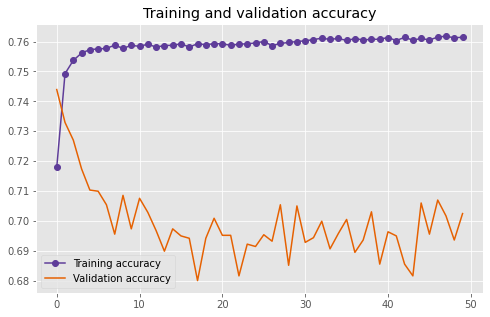

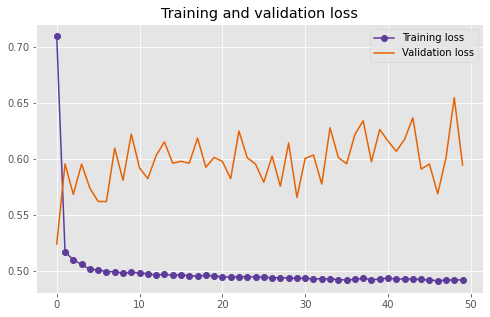

In [55]:
# Plots the accuracy and loss metrics for both the training and validation sets
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['sparse_categorical_accuracy']
    val_accuracy = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)

In [56]:
# Predicts the Round of 64 results
r64_df = prep2023(r64_matchups, teams_df, ppg_df, eff_df, rankings_df)

r64_df = r64_df.dropna()

X_test = r64_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_pred = np.argmax(roundball.predict(X_test), axis = 1)
r64_df['Prob_of_Team1_Win'] = y_pred
r64_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

1/1 [==============================] - 0s 138ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1394,1
1,1268,1452,1
2,1361,1149,1
3,1438,1202,1
4,1166,1301,1
5,1124,1364,1
6,1281,1429,1
7,1112,1343,1
8,1345,1192,1
9,1272,1194,1


In [57]:
# Predicts the Round of 32 results
r32_matchups = MMadness(r64_df, teams_df)

print(r32_matchups)

r32_df = prep2023(r32_matchups, teams_df, ppg_df, eff_df, rankings_df)

r32_df = r32_df.dropna()

X_test = r32_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
r32_df['Prob_of_Team1_Win'] = y_pred
r32_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]




['Alabama', 'Maryland', 'San Diego St', 'Virginia', 'Creighton', 'Baylor', 'Missouri', 'Arizona', 'Purdue', 'Memphis', 'Duke', 'Tennessee', 'Kentucky', 'Kansas St', 'Michigan St', 'Marquette', 'Houston', 'Auburn', 'Miami FL', 'Indiana', 'Iowa St', 'Xavier', 'Texas A&M', 'Texas', 'Kansas', 'Arkansas', "St Mary's CA", 'Connecticut', 'TCU', 'Gonzaga', 'Northwestern', 'UCLA']
1/1 [==============================] - 0s 98ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1268,1
1,1361,1438,1
2,1166,1124,1
3,1281,1112,0
4,1345,1272,1
5,1181,1397,1
6,1246,1243,1
7,1277,1266,0
8,1222,1120,1
9,1274,1231,0


In [58]:
# Predicts the Sweet 16 results
s16_matchups = MMadness(r32_df, teams_df)

print(s16_matchups)

s16_df = prep2023(s16_matchups, teams_df, ppg_df, eff_df, rankings_df)

s16_df = s16_df.dropna()

X_test = s16_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
s16_df['Prob_of_Team1_Win'] = y_pred
s16_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'San Diego St', 'Creighton', 'Arizona', 'Purdue', 'Duke', 'Kentucky', 'Marquette', 'Houston', 'Indiana', 'Xavier', 'Texas', 'Kansas', "St Mary's CA", 'Gonzaga', 'UCLA']
1/1 [==============================] - 0s 28ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1361,1
1,1166,1112,0
2,1345,1181,1
3,1246,1266,1
4,1222,1231,1
5,1462,1400,1
6,1242,1388,1
7,1211,1417,0


In [59]:
# Predicts the Elite 8 results
e8_matchups = MMadness(s16_df, teams_df)

print(e8_matchups)

e8_df = prep2023(e8_matchups, teams_df, ppg_df, eff_df, rankings_df)

e8_df = e8_df.dropna()

X_test = e8_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
e8_df['Prob_of_Team1_Win'] = y_pred
e8_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Arizona', 'Purdue', 'Kentucky', 'Houston', 'Xavier', 'Kansas', 'UCLA']
1/1 [==============================] - 0s 27ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1112,1
1,1345,1246,1
2,1222,1462,1
3,1242,1417,1


In [60]:
# Predicts the Final 4 results
f4_matchups = MMadness(e8_df, teams_df)

print(f4_matchups)

f4_df = prep2023(f4_matchups, teams_df, ppg_df, eff_df, rankings_df)

f4_df = f4_df.dropna()

X_test = f4_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
f4_df['Prob_of_Team1_Win'] = y_pred
f4_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Purdue', 'Houston', 'Kansas']
1/1 [==============================] - 0s 27ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1345,1
1,1222,1242,1


In [61]:
# Predicts the Championship results
champ_matchups = MMadness(f4_df, teams_df)

print(champ_matchups)

champ_df = prep2023(champ_matchups, teams_df, ppg_df, eff_df, rankings_df)

champ_df = champ_df.dropna()

X_test = champ_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
champ_df['Prob_of_Team1_Win'] = y_pred
champ_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Alabama', 'Houston']
1/1 [==============================] - 0s 33ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1104,1222,1


In [62]:
# Predicts the Tounrnamet Winners
winner = MMadness(champ_df, teams_df)
print(winner)

['Alabama']
